# Tutorial 2: Training a spiking neural network on a simple vision dataset

Friedemann Zenke (https://fzenke.net)

> For more details on surrogate gradient learning, please see:
> Neftci, E.O., Mostafa, H., and Zenke, F. (2019). Surrogate Gradient Learning in Spiking Neural Networks.
> https://arxiv.org/abs/1901.09948

In Tutorial 1, we have seen how to train a simple multi-layer spiking neural network on a small synthetic dataset. In this tutorial, we will apply what we have learned so far to a slightly larger dataset.
Concretely, we will use the [Fashion MNIST dataset](https://github.com/zalandoresearch/fashion-mnist).

In [487]:
# !pip install tonic

In [488]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

import torch
import torch.nn as nn
import torchvision

In [489]:
torch.__version__

'2.6.0'

In [490]:
sys.path.append("/Users/naliniramanathan/projects/snn_project/randman")
import randman
from randman import Randman

In [491]:
nb_inputs  = 100 
nb_hidden  = 4
nb_outputs = 2

time_step = 1e-3
nb_steps  = 200

batch_size = 256

nb_samples = batch_size*2

In [492]:
torch.backends.mps.is_available()

True

In [493]:
dtype = torch.float

# Check whether a GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

In [ ]:
def standardize(x,eps=1e-7):
    mi,_ = x.min(0)
    ma,_ = x.max(0)
    return (x-mi)/(ma-mi+eps)

def make_spiking_dataset(nb_classes=10, nb_units=100, nb_steps=100, step_frac=1.0, dim_manifold=2, nb_spikes=1, nb_samples=1000, alpha=2.0, shuffle=True, classification=True, seed=None):
    """ Generates event-based generalized spiking randman classification/regression dataset. 
    In this dataset each unit fires a fixed number of spikes. So ratebased or spike count based decoding won't work. 
    All the information is stored in the relative timing between spikes.
    For regression datasets the intrinsic manifold coordinates are returned for each target.
    Args: 
        nb_classes: The number of classes to generate
        nb_units: The number of units to assume
        nb_steps: The number of time steps to assume
        step_frac: Fraction of time steps from beginning of each to contain spikes (default 1.0)
        nb_spikes: The number of spikes per unit
        nb_samples: Number of samples from each manifold per class
        alpha: Randman smoothness parameter
        shuffe: Whether to shuffle the dataset
        classification: Whether to generate a classification (default) or regression dataset
        seed: The random seed (default: None)
    Returns: 
        A tuple of data,labels. The data is structured as numpy array 
        (sample x event x 2 ) where the last dimension contains 
        the relative [0,1] (time,unit) coordinates and labels.
    """
  
    data = []
    labels = []
    targets = []

    if seed is not None:
        np.random.seed(seed)
    
    max_value = np.iinfo(np.int64).max
    randman_seeds = np.random.randint(max_value, size=(nb_classes,nb_spikes) )

    for k in range(nb_classes):
        x = np.random.rand(nb_samples,dim_manifold)
        submans = [ randman.Randman(nb_units, dim_manifold, alpha=alpha, seed=randman_seeds[k,i]) for i in range(nb_spikes) ]
        units = []
        times = []
        for i,rm in enumerate(submans):
            y = rm.eval_manifold(x)
            y = standardize(y)
            units.append(np.repeat(np.arange(nb_units).reshape(1,-1),nb_samples,axis=0))
            times.append(y.numpy())

        units = np.concatenate(units,axis=1)
        times = np.concatenate(times,axis=1)
        events = np.stack([times,units],axis=2)
        data.append(events)
        labels.append(k*np.ones(len(units)))
        targets.append(x)

    data = np.concatenate(data, axis=0)
    labels = np.array(np.concatenate(labels, axis=0), dtype=np.int64)
    targets = np.concatenate(targets, axis=0)

    if shuffle:
        idx = np.arange(len(data))
        np.random.shuffle(idx)
        data = data[idx]
        labels = labels[idx]
        targets = targets[idx]

    data[:,:,0] *= nb_steps*step_frac
    # data = np.array(data, dtype=int)

    if classification:
        return data, labels
    else:
        return data, targets

In [494]:
# Create our initial spiking dataset
data, labels = make_spiking_dataset(nb_classes=nb_outputs, nb_units=nb_inputs, nb_steps=nb_steps, dim_manifold=3, seed=42, nb_samples=nb_samples)

In [495]:
for sample in data:
    for event in sample:
        print(event)
        break

[7.78721273 0.        ]
[97.73805141  0.        ]
[114.2365098   0.       ]
[100.9521246   0.       ]
[108.10633898   0.        ]
[79.17708158  0.        ]
[90.10779262  0.        ]
[49.92577136  0.        ]
[91.71598554  0.        ]
[90.51468968  0.        ]
[93.16607118  0.        ]
[118.55578423   0.        ]
[92.5745368  0.       ]
[105.08322716   0.        ]
[101.61856413   0.        ]
[95.7496047  0.       ]
[99.64988232  0.        ]
[90.07636309  0.        ]
[109.04083252   0.        ]
[62.08559871  0.        ]
[91.33306146  0.        ]
[109.80587006   0.        ]
[70.46699524  0.        ]
[107.48083591   0.        ]
[106.54876232   0.        ]
[97.7335155  0.       ]
[95.91334462  0.        ]
[92.60609746  0.        ]
[98.31582308  0.        ]
[144.53886747   0.        ]
[138.01026344   0.        ]
[107.81165361   0.        ]
[138.61830235   0.        ]
[161.14584208   0.        ]
[88.75864744  0.        ]
[81.43368959  0.        ]
[71.89377546  0.        ]
[101.06173754   0.  

In [496]:
import torch.nn.functional as F

def preprocess_spike_events(data, nb_steps=nb_steps, nb_units=nb_inputs):
    """
    Convert spike events into a binned spike train.

    Args:
        data: A numpy array of shape (sample x event x 2) where the last dimension contains [time, unit].
        nb_steps: Number of time steps to bin the spikes into.
        nb_units: Number of neurons.

    Returns:
        A binned spike train of shape (nb_steps, nb_units).
    """
    spike_train = np.zeros((nb_steps, nb_units), dtype=np.float32)
    
    for event in data:
        time, unit = event
        if 0 <= time < nb_steps:  # Ensure time is within valid range
            time_bin = int(time)  # Bin time into steps
            neuron_id = int(unit)  # Convert unit to integer (neuron ID)
            if 0 <= neuron_id < nb_units:  # Ensure neuron_id is within valid range
                spike_train[time_bin, neuron_id] = 1  # Set to non-zero value if a spike occurred

    return torch.tensor(spike_train, dtype=torch.float32)

def custom_collate_fn(batch, num_classes=nb_outputs):
    """
    Custom collate function to handle structured data and one-hot encode the labels.

    Args:
        batch: A list of samples (spike_events, label).
        num_classes: Number of classes for one-hot encoding.

    Returns:
        A tuple (spike_tensors, one_hot_labels).
    """
    spike_tensors = []
    labels = []
    # print(f"Processing batch of size {len(batch)}")  # Debug log

    for spike_events, label in batch:
        # print(f"Processing sample with {len(data)} events")  # Debug log
        # Preprocess spike events
        # print(spike_events)
        spike_tensor = preprocess_spike_events(spike_events)
        spike_tensors.append(spike_tensor)

        # One-hot encode the label
        one_hot_label = F.one_hot(torch.tensor(label, dtype=torch.int64), num_classes=num_classes)
        labels.append(one_hot_label)

    # Stack spike tensors and labels into batches
    spike_tensors = torch.stack(spike_tensors)
    labels = torch.stack(labels)  # Convert list of one-hot labels into a batch
    return spike_tensors, labels


In [497]:
from torch.utils.data import DataLoader, TensorDataset, random_split

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)


data_tensor = torch.tensor(data, dtype=torch.float32)  # Shape: (num_samples, num_events, 2)
labels_tensor = torch.tensor(labels, dtype=torch.int64)  # Shape: (num_samples,)

# Combine data and labels into a PyTorch Dataset
dataset = TensorDataset(data_tensor, labels_tensor)

# Define the sizes for train and test subsets
train_ratio = 0.8  # 80% for training, 20% for testing
train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size

# Split the dataset into train and test subsets
train_subset, test_subset = random_split(dataset, [train_size, test_size])


# Create a DataLoader with the custom collate function
train_loader = DataLoader(
    train_subset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=custom_collate_fn,
    pin_memory=True,
    drop_last=True
)

test_loader = DataLoader(
    test_subset,
    batch_size=batch_size,
    shuffle=False,  # No need to shuffle the test set
    collate_fn=custom_collate_fn,
    pin_memory=True,
    drop_last=False  # Keep all samples in the test set
)

# Iterate through the DataLoader
print(f"Train subset size: {len(train_subset)}")
print(f"Test subset size: {len(test_subset)}")

Train subset size: 819
Test subset size: 205


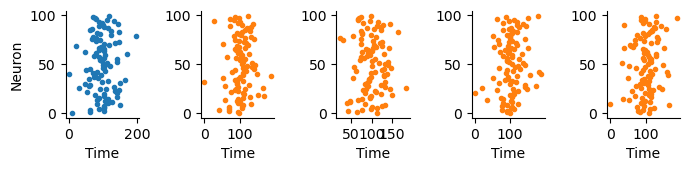

In [498]:
# Show spike raster plots four random example inputs
gs = GridSpec(1,5)
fig = plt.figure(figsize=(7,1.8),dpi=100)

for i in range(5):    
    ax = fig.add_subplot(gs[i])
    ax.scatter(data[i,:,0], data[i,:,1], marker=".", color=sns.color_palette()[labels[i]])
    ax.set_xlabel("Time")
    if i==0: ax.set_ylabel("Neuron")
    
plt.tight_layout()
sns.despine()

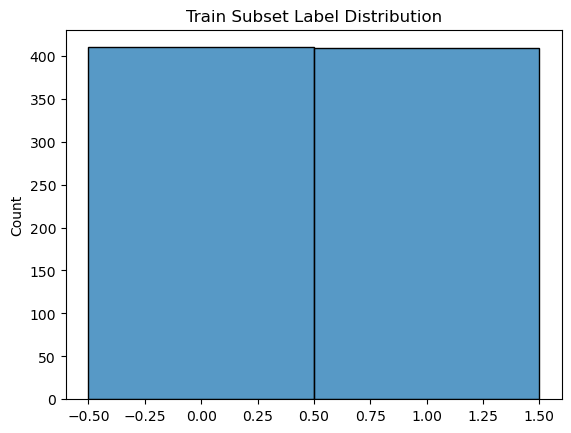

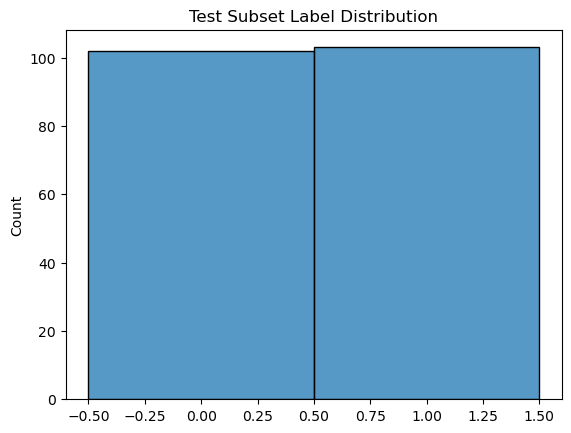

In [499]:
# Check distribution for each subset using train_loader.dataset[i][1]
train_labels = [int(train_loader.dataset[i][1]) for i in range(len(train_loader.dataset))]
test_labels = [int(test_loader.dataset[i][1]) for i in range(len(test_loader.dataset))]
sns.histplot(train_labels, discrete=True)
plt.title('Train Subset Label Distribution')
plt.show()
sns.histplot(test_labels, discrete=True)
plt.title('Test Subset Label Distribution')
plt.show()

Since we are working with spiking neural networks, we ideally want to use a temporal code to make use of spike timing. To that end, we will use a spike latency code to feed spikes to our network.

### Setup of the spiking network model

In [500]:
tau_mem = 10e-3
tau_syn = 5e-3

alpha   = float(np.exp(-time_step/tau_syn))
beta    = float(np.exp(-time_step/tau_mem))

In [501]:
weight_scale = 7*(1.0-beta) # this should give us some spikes to begin with

w1 = torch.empty((nb_inputs, nb_hidden),  device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w1, mean=0.0, std=weight_scale/np.sqrt(nb_inputs))

w2 = torch.empty((nb_hidden, nb_outputs), device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w2, mean=0.0, std=weight_scale/np.sqrt(nb_hidden))

print("init done")

init done


In [502]:
def plot_voltage_traces(mem, spk=None, dim=(3,5), spike_height=5):
    gs=GridSpec(*dim)
    if spk is not None:
        dat = 1.0*mem
        dat[spk>0.0] = spike_height
        dat = dat.detach().cpu().numpy()
    else:
        dat = mem.detach().cpu().numpy()
    for i in range(np.prod(dim)):
        if i==0: a0=ax=plt.subplot(gs[i])
        else: ax=plt.subplot(gs[i],sharey=a0)
        ax.plot(dat[i])
        ax.axis("off")

We can now run this code and plot the output layer "membrane potentials" below. As desired, these potentials do not have spikes riding on them.

## Training the network

In [503]:
class SurrGradSpike(torch.autograd.Function):
    """
    Here we implement our spiking nonlinearity which also implements
    the surrogate gradient. By subclassing torch.autograd.Function,
    we will be able to use all of PyTorch's autograd functionality.
    Here we use the normalized negative part of a fast sigmoid
    as this was done in Zenke & Ganguli (2018).
    """

    scale = 100.0 # controls steepness of surrogate gradient

    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we compute a step function of the input Tensor
        and return it. ctx is a context object that we use to stash information which
        we need to later backpropagate our error signals. To achieve this we use the
        ctx.save_for_backward method.
        """
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        return out

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor we need to compute the
        surrogate gradient of the loss with respect to the input.
        Here we use the normalized negative part of a fast sigmoid
        as this was done in Zenke & Ganguli (2018).
        """
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad = grad_input/(SurrGradSpike.scale*torch.abs(input)+1.0)**2
        return grad

# here we overwrite our naive spike function by the "SurrGradSpike" nonlinearity which implements a surrogate gradient
spike_fn  = SurrGradSpike.apply

In [504]:
def run_snn(inputs):
    h1 = torch.einsum("abc,cd->abd", (inputs, w1))
    syn = torch.zeros((batch_size,nb_hidden), device=device, dtype=dtype)
    mem = torch.zeros((batch_size,nb_hidden), device=device, dtype=dtype)

    mem_rec = []
    spk_rec = []

    # Compute hidden layer activity
    for t in range(nb_steps):
        mthr = mem-1.0
        out = spike_fn(mthr)
        rst = out.detach() # We do not want to backprop through the reset
        # print(f"h1[:, t] shape: {h1[:, t].shape}")
        # print(f"syn shape: {syn.shape}")

        new_syn = alpha*syn +h1[:,t]
        new_mem = (beta*mem +syn)*(1.0-rst)

        mem_rec.append(mem)
        spk_rec.append(out)

        mem = new_mem
        syn = new_syn

    mem_rec = torch.stack(mem_rec,dim=1)
    spk_rec = torch.stack(spk_rec,dim=1)

    # Readout layer
    h2= torch.einsum("abc,cd->abd", (spk_rec, w2))
    flt = torch.zeros((batch_size,nb_outputs), device=device, dtype=dtype)
    out = torch.zeros((batch_size,nb_outputs), device=device, dtype=dtype)
    out_rec = [out]
    for t in range(nb_steps):
        new_flt = alpha*flt +h2[:,t]
        new_out = beta*out +flt

        flt = new_flt
        out = new_out

        out_rec.append(out)

    out_rec = torch.stack(out_rec,dim=1)
    other_recs = [mem_rec, spk_rec]
    return out_rec, other_recs

In [523]:
from tqdm import tqdm  # Import tqdm

import torch.optim as optim

def train(train_loader, lr=2e-3, nb_epochs=10):
    params = [w1,w2]
    optimizer = torch.optim.Adam(params, lr=lr, betas=(0.9,0.999))

    log_softmax_fn = nn.LogSoftmax(dim=1)
    loss_fn = nn.NLLLoss()

    loss_hist = []

    # scaler = torch.amp.GradScaler(device=device) if device.type == 'cuda' else None

    for e in range(nb_epochs):
        local_loss = []
        # with tqdm(train_loader, desc=f"Epoch {e+1}/{nb_epochs}", unit="batch") as t:
        for x_local, y_local in train_loader:
            x_local = x_local.to(device)
            y_local = y_local.to(device)

            # print(f"Input dimensions: x_local.shape = {x_local.shape}, y_local.shape = {y_local.shape}")

            # # with torch.amp.autocast(device_type=device.type, enabled=(scaler is not None)):  # Mixed Precision

            #     print(f"Output dimensions: output.shape = {output.shape}")

            output, _ = run_snn(x_local)  # Assuming run_snn() is integrated into model
            log_p_y = log_softmax_fn(output)  # LogSoftmax across all classes
            loss_val = loss_fn(log_p_y, y_local)

            # Backward pass
            # if scaler:  # Mixed precision handling
            #     scaler.scale(loss_val).backward()
            #     scaler.step(optimizer)
            #     scaler.update()
            # else:
            loss_val.backward()
            optimizer.step()

            # t.set_postfix(loss=loss_val.item())

            local_loss.append(loss_val.item())
        mean_loss = np.mean(local_loss)
        # print("Epoch %i: loss=%.5f"%(e+1,mean_loss))
        loss_hist.append(mean_loss)

    return loss_hist

from sklearn.metrics import confusion_matrix


def compute_classification_accuracy(data_loader):
    """ 
    Computes classification accuracy and confusion matrix on supplied data in batches.
    
    Returns:
        accuracy: Overall classification accuracy.
        conf_matrix: Confusion matrix of shape (num_classes, num_classes).
    """
    accs = []
    all_preds = []
    all_labels = []

    for x_local, y_local in data_loader:
        # Move data to the appropriate device
        x_local, y_local = x_local.to(device), y_local.to(device)

        # Run the SNN model
        output, _ = run_snn(x_local)

        # Compute predictions
        m, _ = torch.max(output, 1)  # Max over time
        _, preds = torch.max(m, 1)   # Argmax over output units

        # Convert one-hot encoded labels to class indices
        y_local_indices = torch.argmax(y_local, 1)  # Shape: [batch_size]

        # Compute accuracy for the current batch
        correct = (y_local_indices == preds).float()  # Shape: [batch_size]
        tmp = correct.mean().item()  # Accuracy for the current batch
        accs.append(tmp)

        # Store predictions and labels for the confusion matrix
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_local_indices.cpu().numpy())

    # Compute overall accuracy
    accuracy = np.mean(accs)

    # Compute confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)

    return accuracy, conf_matrix

In [524]:
loss_hist = train(train_loader, lr=2e-4, nb_epochs=1000)

/var/folders/7b/0zqwym191dq_5jvhhbf5lfgr0000gn/T/ipykernel_21838/2826913564.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  one_hot_label = F.one_hot(torch.tensor(label, dtype=torch.int64), num_classes=num_classes)


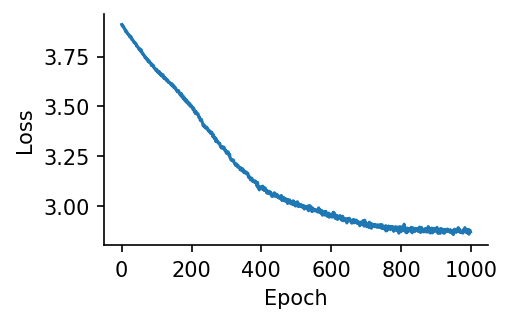

In [525]:
plt.figure(figsize=(3.3,2),dpi=150)
plt.plot(loss_hist)
plt.xlabel("Epoch")
plt.ylabel("Loss")
sns.despine()

In [526]:
def plot_confusion_matrix(conf_matrix, class_names):
    """ Plots the confusion matrix. """
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

/var/folders/7b/0zqwym191dq_5jvhhbf5lfgr0000gn/T/ipykernel_21838/2826913564.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  one_hot_label = F.one_hot(torch.tensor(label, dtype=torch.int64), num_classes=num_classes)


Train Accuracy: 49.87%


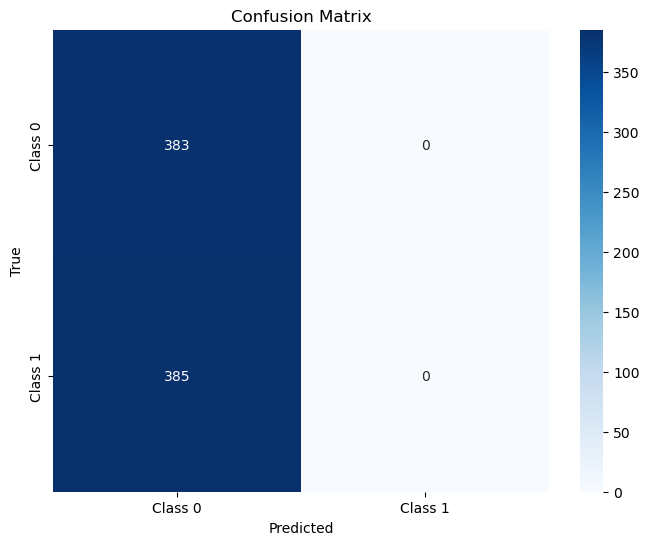

In [527]:
train_accuracy, train_conf_matrix = compute_classification_accuracy(train_loader)

# Print results
print(f"Train Accuracy: {train_accuracy * 100:.2f}%")
class_names = [f"Class {i}" for i in range(nb_outputs)]

# Plot the confusion matrix
plot_confusion_matrix(train_conf_matrix, class_names)


In [528]:
test_accuracy, test_conf_matrix = compute_classification_accuracy(test_loader)

# Print results
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
class_names = [f"Class {i}" for i in range(nb_outputs)]

# Plot the confusion matrix
plot_confusion_matrix(test_conf_matrix, class_names)


/var/folders/7b/0zqwym191dq_5jvhhbf5lfgr0000gn/T/ipykernel_21838/2826913564.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  one_hot_label = F.one_hot(torch.tensor(label, dtype=torch.int64), num_classes=num_classes)


RuntimeError: The size of tensor a (256) must match the size of tensor b (205) at non-singleton dimension 0

In [ ]:
def get_mini_batch(data_loader, shuffle=False):
    for ret in data_loader:
        return ret

In [ ]:
x_batch, y_batch = get_mini_batch(test_loader)
x_batch = x_batch.to(device)
output, other_recordings = run_snn(x_batch)
mem_rec, spk_rec = other_recordings

/var/folders/7b/0zqwym191dq_5jvhhbf5lfgr0000gn/T/ipykernel_21838/2826913564.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  one_hot_label = F.one_hot(torch.tensor(label, dtype=torch.int64), num_classes=num_classes)


In [ ]:
print("mem_rec shape:", mem_rec.shape)
print("spk_rec shape:", spk_rec.shape)

mem_rec shape: torch.Size([20, 200, 100])
spk_rec shape: torch.Size([20, 200, 100])


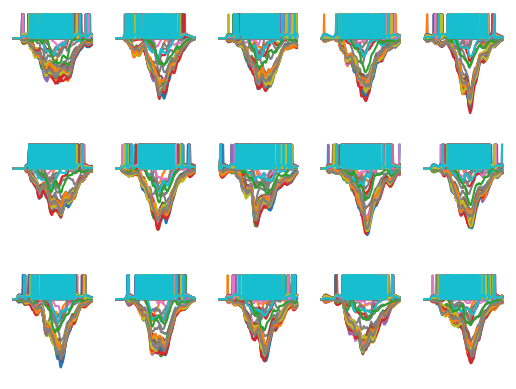

In [ ]:
fig=plt.figure(dpi=100)
plot_voltage_traces(mem_rec, spk_rec)

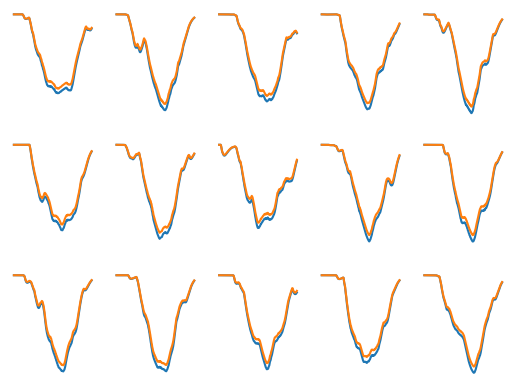

In [ ]:
fig=plt.figure(dpi=100)
plot_voltage_traces(output)

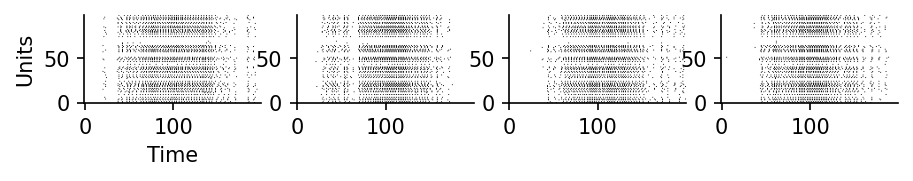

In [ ]:
# Let's plot the hiddden layer spiking activity for some input stimuli

nb_plt = 4
gs = GridSpec(1,nb_plt)
fig= plt.figure(figsize=(7,3),dpi=150)
for i in range(nb_plt):
    plt.subplot(gs[i])
    plt.imshow(spk_rec[i].detach().cpu().numpy().T,cmap=plt.cm.gray_r, origin="lower" )
    if i==0:
        plt.xlabel("Time")
        plt.ylabel("Units")

    sns.despine()

In conclusion, we see that already this simple spiking network solves the classification problem with ~85% accuracy, and there is plenty of room left for tweaking. However, the hidden layer activities do not look very biological. Although the network displays population sparseness in that only a subset of neurons are active at any given time, the individual neurons' firing rates are pathologically high. This pathology is not too surprising since we have not incentivized low activity levels in any way. We will create such an incentive to address this issue by activity regularization in one of the next tutorials.

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.